# [Autoencoders](https://arxiv.org/abs/2201.03898)

CNN을 훈련할 때 발생하는 문제 중 하나는 많은 레이블이 지정된 데이터가 필요하다는 것인데 이미지 분류의 경우 이미지를 여러 클래스로 분리해야 하는데, 이는 수작업으로 수행

하지만 원시(레이블이 없는) 데이터를 사용하여 CNN 특징 추출기를 훈련할 수 있는데, 이를 **자기 지도 학습**이라고 함
- 레이블 대신 훈련 이미지를 네트워크 입력과 출력으로 사용
- 자동 인코더의 주요 아이디어는 입력 이미지를 어떤 **잠재 공간**으로 변환하는 **인코더 네트워크**(일반적으로 더 작은 크기의 벡터)와 원본 이미지를 재구성하는 것이 목표인 **디코더 네트워크**를 갖는다는 것

정확한 재구성을 위해 원본 이미지에서 최대한 많은 정보를 캡처하도록 자동 인코더를 학습시키기 때문에, 네트워크는 입력 이미지의 의미를 포착할 수 있는 최적의 **임베딩**을 찾으려고 함

Let's create simplest autoencoder for MNIST

In [1]:
# 파이토치(PyTorch)와 관련된 라이브러리들을 임포트하고, 난수 생성을 위한 시드를 설정

%pip install torch
%pip install torchvision
%pip install matplotlib

# 필요한 모듈과 라이브러리를 임포트
# 딥러닝 모델을 구축하고, 훈련하며, 결과를 시각화하는 데 필요
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from torch import nn
from torch import optim
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F

# PyTorch와 NumPy의 난수 생성기에 시드 값을 설정
# 코드 실행 결과의 일관성과 재현성을 보장
torch.manual_seed(42)
np.random.seed(42)


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


학습 매개변수를 정의하고 GPU를 사용할 수 있는지 확인

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
train_size = 0.9 # 데이터 세트의 90%를 훈련 데이터로 사용하고 나머지 10%는 검증 또는 테스트 용도로 사용하기 위해 설정된 비율
lr = 1e-3
eps = 1e-8 # 수치 계산 시 0으로 나누는 것을 방지하기 위해 사용되는 매우 작은 값을 최적화 알고리즘에서 안정성을 높이기 위해 사용
batch_size = 256
epochs = 30

MNIST 데이터 세트를 로드하고 지정된 변환을 적용합니다. 또한 이를 훈련/테스트 데이터 세트로 분할

In [3]:
def mnist(train_part, transform=None):
    dataset = torchvision.datasets.MNIST('.', download=True, transform=transform)
    # 함수 인자로 받은 train_part는 훈련 데이터셋의 비율을 결정
    # 예를 들어, 0.9를 인자로 주면 데이터의 90%를 훈련용으로 사용
    train_part = int(train_part * len(dataset))
    # 전체 데이터셋에서 train_part 비율만큼을 훈련 데이터셋으로, 나머지를 테스트 데이터셋으로 분할
    # 이 분할은 torch.utils.data.random_split 함수를 사용하여 무작위로 수행
    # 분할 비율은 train_part 계산을 통해 결정
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_part, len(dataset) - train_part])
    return train_dataset, test_dataset

데이터 세트를 로드하고 학습 및 테스트를 위한 데이터 로더를 정의

In [4]:
# transforms.Compose를 사용해 데이터에 적용할 전처리 단계를 정의
# transforms.ToTensor()를 통해 이미지 데이터를 PyTorch 텐서로 변환하고, 픽셀 값의 범위를 [0, 255]에서 [0.0, 1.0]으로 조정
transform = transforms.Compose([transforms.ToTensor()])

# transform과 함께 mnist 함수를 호출하여 훈련 데이터와 테스트 데이터를 분할
# train_size 변수를 사용하여 데이터의 어떤 비율을 훈련 데이터로 사용할지 결정
train_dataset, test_dataset = mnist(train_size, transform)

# 훈련 데이터셋을 로드하기 위한 DataLoader를 생성
# DataLoader는 데이터셋의 마지막 배치를 버릴지 결정하는 drop_last=True 옵션을 포함하며, 배치 크기(batch_size)와 데이터셋 셔플 여부(shuffle=True)를 지정
# 셔플은 각 에폭마다 데이터의 순서를 무작위로 섞어, 모델이 데이터의 특정 순서에 의존하지 않도록 함
train_dataloader = torch.utils.data.DataLoader(train_dataset, drop_last=True, batch_size=batch_size, shuffle=True)

# 테스트 데이터셋을 로드하기 위한 DataLoader를 생성
# DataLoader는 배치 크기를 1로 설정하여 각각의 테스트 샘플을 독립적으로 평가
# 셔플을 비활성화(shuffle=False)하여 테스트 데이터의 순서를 유지
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

# 훈련과 테스트 DataLoader를 튜플로 묶어 다른 부분의 코드에서 쉽게 사용할 수 있도록 함
dataloaders = (train_dataloader, test_dataloader)

In [5]:
# 주어진 데이터셋의 이미지를 시각화하는 역할
# 사용자가 설정할 수 있는 몇 가지 옵션을 포함하여 유연하게 이미지를 처리하고 표시할 수 있음

def plotn(n, data, noisy=False, super_res=None):

# 파라미터
# n: 표시할 이미지의 수
# data: 시각화할 데이터셋으로 각 원소는 이미지를 포함
# noisy: Boolean 값으로, 이미지에 잡음을 추가할지 여부를 결정
# super_res: 수퍼 해상도 비율을 설정하는데 이미지를 다운샘플링하기 위해 사용

    fig, ax = plt.subplots(1, n)
    for i, z in enumerate(data):
        if i == n:
            break

        # 이미지 전처리
        # 데이터의 각 이미지(z[0])를 적절한 형태로 재구성
        # 이미지가 28x28 또는 14x14 크기인지에 따라 다르게 처리
        # super_res가 설정된 경우, transforms.Resize를 사용하여 이미지 크기를 변경

        preprocess = z[0].to('cpu').reshape(1, 28, 28) if z[0].shape[1] == 28 else z[0].to('cpu').reshape(1, 14, 14) if z[0].shape[1] == 14 else z[0].to('cpu')
        if super_res is not None:
            _transform = transforms.Resize((int(preprocess.shape[1] / super_res), int(preprocess.shape[2] / super_res)))
            preprocess = _transform(preprocess)

        # 잡음 추가
        # noisy가 참인 경우, noisify 함수를 호출하여 이미지에 잡음을 추가
        # 일반적으로 데이터의 로버스트성을 테스트하기 위해 사용

        if noisy:
            shapes = list(preprocess.shape)
            preprocess += noisify(shapes)

        # 이미지 표시
        # matplotlib.pyplot.subplots를 사용하여 시각화할 이미지의 갯수에 맞는 subplot을 생성
        # 각 subplot에 이미지를 표시
        # ax[i].imshow(preprocess[0])는 i번째 subplot에 처리된 이미지를 표시

        ax[i].imshow(preprocess[0])
        
    # 모든 subplot을 포함하는 그래프를 화면에 표시
    plt.show()

In [6]:
# 이미지에 잡음을 추가하기 위해 정규 분포를 따르는 랜덤 값을 생성하는 기능을 제공
# 특히 이미지 데이터의 로버스트성을 테스트하거나 데이터 증강을 수행할 때 유용하게 사용

# 입력 파라미터
# shapes: 잡음을 추가할 데이터의 차원을 지정
# 이미지 데이터의 형태(예: (1, 28, 28))와 일치해야 함

# 잡음 생성
# np.random.normal: 넘파이의 정규 분포 함수를 사용하여 잡음 데이터를 생성
# loc=0.5: 잡음의 평균값(mean)을 0.5로 설정
# 이미지의 픽셀 값 범위가 0.0에서 1.0 사이인 경우, 이 평균값은 픽셀 값을 중간 수준으로 밀어놓으려는 의도
# scale=0.3: 표준 편차(standard deviation)를 0.3으로 설정하여, 생성되는 잡음 값의 분포 범위를 정함
# 이 값이 크면 잡음의 변동 폭이 커짐
# size=shapes: 생성될 잡음 데이터의 크기를 입력 파라미터로 받은 shapes와 동일하게 설정

# 출력
# 함수는 지정된 차원과 통계적 특성을 갖는 잡음 배열을 반환
# 이 배열은 원본 이미지 데이터에 더해져 잡음이 섞인 이미지를 생성하는 데 사용

def noisify(shapes):
    return np.random.normal(loc=0.5, scale=0.3, size=shapes)


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


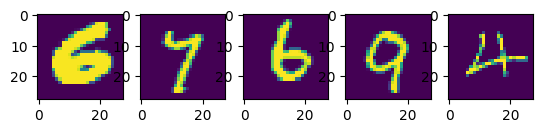

In [8]:
%pip install --upgrade numpy

plotn(5, train_dataset)

In [9]:
#  PyTorch의 nn.Module을 상속받아 컨볼루션 신경망을 구현
# 주로 이미지 데이터의 차원을 축소하거나 중요한 특징을 추출하는 데 사용

class Encoder(nn.Module):
    def __init__(self): # 클래스 초기화
        super().__init__() # Python의 상속 메커니즘을 통해 nn.Module의 초기화 메서드를 호출
        
        # 첫 번째 컨볼루션 레이어로, 입력 채널 1개를 받아 16개의 출력 채널로 매핑
        # 커널 크기는 3x3이며, padding='same'은 입력과 출력의 공간적 차원을 동일하게 유지
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(3, 3), padding='same')
        
        # 첫 번째 맥스 풀링 레이어로, 2x2의 윈도우 크기를 사용해 공간적 차원을 줄임
        # 특징의 공간적 크기를 감소시키면서 중요한 정보는 유지
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv2 = nn.Conv2d(16, 8, kernel_size=(3, 3), padding='same')
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv3 = nn.Conv2d(8, 8, kernel_size=(3, 3), padding='same')
        
        # 세 번째 맥스 풀링 레이어로, 패딩이 (1, 1)로 설정되어 있어 풀링 과정에서 입력의 가장자리 부분도 고려
        self.maxpool3 = nn.MaxPool2d(kernel_size=(2, 2), padding=(1, 1))
        
        # 활성화 함수로 ReLU(Rectified Linear Unit)를 사용
        # ReLU는 음수 입력에 대해 0을 출력하고, 양수 입력에 대해서는 입력을 그대로 출력
        self.relu = nn.ReLU()

    # 입력 이미지 input은 차례대로 각 컨볼루션 레이어와 ReLU 활성화 함수를 거친 다음, 맥스 풀링 레이어를 통과
    # 이 과정을 통해 입력 데이터의 차원이 축소되고, 중요한 특징들을 추출
    def forward(self, input):
        
        # hidden1, hidden2, encoded는 각각의 중간 단계에서 생성된 특징 맵(feature map)을 나타냄
        hidden1 = self.maxpool1(self.relu(self.conv1(input)))
        hidden2 = self.maxpool2(self.relu(self.conv2(hidden1)))
        encoded = self.maxpool3(self.relu(self.conv3(hidden2)))
        
        # 최종적으로 encoded라는 이름의 특징 맵이 반환됨
        # 이 특징 맵은 입력 이미지가 고차원에서 저차원으로 정보가 압축된 결과
        return encoded

In [10]:
# PyTorch의 nn.Module을 상속받아 이미지나 다른 고차원 데이터를 복원하는 딥러닝 모델의 디코더 부분을 구현
# 압축된 특징을 입력으로 받아 원본 데이터의 고차원 형태로 복원하는 역할

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        # 입력 채널 8개를 받아 출력 채널 8개로 매핑하는 첫 번째 컨볼루션 레이어
        # 커널 크기는 3x3이며, 패딩은 'same'으로 설정
        self.conv1 = nn.Conv2d(8, 8, kernel_size=(3, 3), padding='same')
        
        # 첫 번째 업샘플링 레이어로, 공간적 차원을 2배로 확대
        # 맥스 풀링으로 감소된 차원을 다시 확대하는 데 사용
        self.upsample1 = nn.Upsample(scale_factor=(2, 2))
        self.conv2 = nn.Conv2d(8, 8, kernel_size=(3, 3), padding='same')
        self.upsample2 = nn.Upsample(scale_factor=(2, 2))
        self.conv3 = nn.Conv2d(8, 16, kernel_size=(3, 3))
        self.upsample3 = nn.Upsample(scale_factor=(2, 2))
        self.conv4 = nn.Conv2d(16, 1, kernel_size=(3, 3), padding='same')
        self.relu = nn.ReLU()
        
        # 출력 레이어에 시그모이드 활성화 함수를 사용
        # 최종 출력을 [0, 1] 범위로 제한하기 위해 사용
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        hidden1 = self.upsample1(self.relu(self.conv1(input)))
        hidden2 = self.upsample2(self.relu(self.conv2(hidden1)))
        hidden3 = self.upsample3(self.relu(self.conv3(hidden2)))
        decoded = self.sigmoid(self.conv4(hidden3))
        
        #  마지막 컨볼루션 레이어와 시그모이드 활성화 함수를 거쳐 최종적으로 복원된 이미지
        # 원본 데이터와 비슷한 형태를 가지며, 값의 범위는 [0, 1]
        return decoded

In [11]:
# 이미지 또는 다른 데이터 유형의 자동 인코딩과 디코딩을 수행하는 PyTorch의 nn.Module을 상속받은 모듈
# 입력 데이터를 압축(인코딩)하고 이를 다시 복원(디코딩)하는 기능을 갖추고 있으며, 선택적으로 고해상도(슈퍼 해상도) 인코딩을 지원
class AutoEncoder(nn.Module):
    def __init__(self, super_resolution=False):
        super().__init__()
        
        # Boole 매개변수를 통해 모델이 일반 인코더를 사용할지, 아니면 고해상도를 위한 특별한 인코더(SuperResolutionEncoder)를 사용할지 결정
        if not super_resolution:
            self.encoder = Encoder()
        else:
            self.encoder = SuperResolutionEncoder()
        
        # 데이터를 복원하는 Decoder 클래스의 인스턴스를 생성
        self.decoder = Decoder()

    def forward(self, input):
        
        # self.encoder(input)을 호출하여 입력 데이터를 인코딩(압축)
        # 입력 데이터의 차원을 줄이면서 중요한 특징을 유지
        encoded = self.encoder(input)
        
        # 인코딩된 데이터를 다시 복원
        # 복원 과정은 인코딩 과정에서 손실된 정보를 최소화하면서 원본 데이터와 비슷한 형태로 재구성
        decoded = self.decoder(encoded)
        return decoded

In [14]:
# PyTorch를 사용해 오토인코더 모델을 생성하고 설정하는 과정

# AutoEncoder 클래스의 인스턴스를 생성
# 입력 데이터를 압축하는 인코더와 압축된 데이터를 복원하는 디코더를 포함
model = AutoEncoder().to(device)

# 옵티마이저 설정
# Adam 최적화 알고리즘을 사용
# Adam은 경사 하강법의 변형으로, 각 매개변수의 학습 속도를 적응적으로 조정
# model.parameters(): 최적화할 모델 매개변수를 가져옴
# lr: 학습률(learning rate)로, 모델이 학습하는 속도를 결정
# eps: Adam 최적화에서 안정성을 보장하기 위한 매우 작은 값
optimizer = optim.Adam(model.parameters(), lr=lr, eps=eps)

# 손실함수
# nn.BCELoss(): 이진 교차 엔트로피 손실(Binary Cross-Entropy Loss)을 사용
# 주로 이진 분류 문제에서 사용되며, 오토인코더의 출력과 실제 값 사이의 차이를 측정하는 데 적합
# 출력이 [0, 1] 범위인 경우(시그모이드 활성화 함수 사용)
# BCELoss는 효과적
loss_fn = nn.BCELoss()

In [15]:
# 오토인코더 모델의 훈련 과정을 제어하는 함수
# 입력 데이터에 잡음을 추가하거나 수퍼 해상도 변환을 적용한 뒤, 모델을 통해 데이터를 인코딩 및 디코딩하여 원본 데이터와의 손실을 최소화하는 방식으로 작동

# 훈련 및 테스트 과정
# 각 에폭마다 모델을 훈련 모드로 설정한 후, 훈련 데이터로더를 통해 배치를 순차적으로 처리
# 입력 이미지에 수퍼 해상도 또는 잡음을 추가한 뒤, 모델을 통해 결과를 예측하고 손실을 계산
# 손실에 대한 역전파를 수행하고 최적화기로 가중치를 업데이트
# 테스트 과정은 훈련과 유사하나, 모델을 평가 모드로 설정하고 역전파나 가중치 업데이트를 수행하지 않음
# 테스트 데이터로더를 통해 모델의 성능을 평가

# 손실 및 진행 상태 추적
# train_loss와 test_loss는 각각 훈련과 테스트 데이터셋에 대한 손실을 누적
# 각 에폭의 끝에서 평균 손실을 계산하고, 이를 tqdm 반복자의 상태 바에 출력하여 훈련 과정을 시각적으로 모니터

def train(dataloaders, model, loss_fn, optimizer, epochs, device, noisy=None, super_res=None):
    tqdm_iter = tqdm(range(epochs))
    train_dataloader, test_dataloader = dataloaders[0], dataloaders[1]

    for epoch in tqdm_iter:
        model.train()
        train_loss = 0.0
        test_loss = 0.0

        for batch in train_dataloader:
            imgs, labels = batch
            shapes = list(imgs.shape)

            if super_res is not None:
                shapes[2], shapes[3] = int(shapes[2] / super_res), int(shapes[3] / super_res)
                _transform = transforms.Resize((shapes[2], shapes[3]))
                imgs_transformed = _transform(imgs)
                imgs_transformed = imgs_transformed.to(device)

            imgs = imgs.to(device)
            labels = labels.to(device)

            if noisy is not None:
                noisy_tensor = noisy[0]
            else:
                noisy_tensor = torch.zeros(tuple(shapes)).to(device)

            if super_res is None:
                imgs_noisy = imgs + noisy_tensor
            else:
                imgs_noisy = imgs_transformed + noisy_tensor

            imgs_noisy = torch.clamp(imgs_noisy, 0., 1.)

            preds = model(imgs_noisy)
            loss = loss_fn(preds, imgs)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        model.eval()
        with torch.no_grad():
            for batch in test_dataloader:
                imgs, labels = batch
                shapes = list(imgs.shape)

                if super_res is not None:
                    shapes[2], shapes[3] = int(shapes[2] / super_res), int(shapes[3] / super_res)
                    _transform = transforms.Resize((shapes[2], shapes[3]))
                    imgs_transformed = _transform(imgs)
                    imgs_transformed = imgs_transformed.to(device)


                imgs = imgs.to(device)
                labels = labels.to(device)

                if noisy is not None:
                    test_noisy_tensor = noisy[1]
                else:
                    test_noisy_tensor = torch.zeros(tuple(shapes)).to(device)

                if super_res is None:
                    imgs_noisy = imgs + test_noisy_tensor
                else:
                    imgs_noisy = imgs_transformed + test_noisy_tensor

                imgs_noisy = torch.clamp(imgs_noisy, 0., 1.)

                preds = model(imgs_noisy)
                loss = loss_fn(preds, imgs)

                test_loss += loss.item()

        train_loss /= len(train_dataloader)
        test_loss /= len(test_dataloader)

        tqdm_dct = {'train loss:': train_loss, 'test loss:': test_loss}
        tqdm_iter.set_postfix(tqdm_dct, refresh=True)
        tqdm_iter.refresh()

In [16]:
train(dataloaders, model, loss_fn, optimizer, epochs, device)

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [19:47<00:00, 39.58s/it, train loss:=0.104, test loss:=0.104]


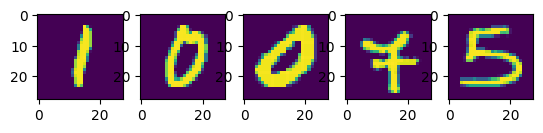

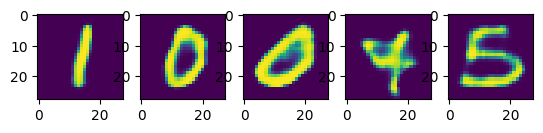

In [17]:
# 모델을 평가 모드로 전환
# 드롭아웃이나 배치 정규화와 같은 훈련 중에만 활성화되어야 하는 기능들을 비활성화
# 모델이 일관된 예측을 생성할 수 있음

model.eval()
predictions = [] # 예측 결과를 저장할 빈 리스트를 초기화
plots = 5

# 테스트 데이터셋을 순회하면서 각 샘플을 처리
# i는 인덱스, data는 각 데이터 포인트
for i, data in enumerate(test_dataset):
    if i == plots:
        break
    
    # 모델에 입력 데이터를 전달하고, 예측 결과를 predictions 리스트에 추가
    # data[0].to(device).unsqueeze(0)은 이미지 데이터를 모델 입력에 맞게 처리
    # 데이터를 대상 장치로 이동시키고, 배치 차원을 추가
    # detach().cpu()는 계산 그래프에서 예측 결과를 분리하고 CPU로 이동
    predictions.append(model(data[0].to(device).unsqueeze(0)).detach().cpu())
plotn(plots, test_dataset) # 테스트 데이터셋에서 처음 5개 샘플을 시각화
plotn(plots, predictions) # 모델이 생성한 예측 결과를 시각화

## Denoising

Autoencoders can be effectively used to remove noise from images. In order to train denoiser, we will start with noise-free images, and add artificial noise to them. Then, we will feed autoencoder with noisy images as input, and noise-free images as output.

Let's see how this works for MNIST:

In [ ]:
plotn(5, train_dataset, noisy=True)

In [ ]:
model = AutoEncoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, eps=eps)
loss_fn = nn.BCELoss()

In [ ]:
noisy_tensor = torch.FloatTensor(noisify([256, 1, 28, 28])).to(device)
test_noisy_tensor = torch.FloatTensor(noisify([1, 1, 28, 28])).to(device)
noisy_tensors = (noisy_tensor, test_noisy_tensor)

In [ ]:
train(dataloaders, model, loss_fn, optimizer, 100, device, noisy=noisy_tensors)

In [ ]:
model.eval()
predictions = []
noise = []
plots = 5
for i, data in enumerate(test_dataset):
    if i == plots:
        break
    shapes = data[0].shape
    noisy_data = data[0] + test_noisy_tensor[0].detach().cpu()
    noise.append(noisy_data)
    predictions.append(model(noisy_data.to(device).unsqueeze(0)).detach().cpu())
plotn(plots, noise)
plotn(plots, predictions)

## Super-Resolution

Similarly to denoiser, we can train autoencoders to increase the resolution of the image. To train super-resolution network, we will start with high-resolution images, and automatically downscale them to produce network inputs. We will then feed autoencoder with small images as inputs and high-resolution images as outputs.

For that let's downscale image to 14x14 at train.

In [ ]:
super_res_koeff = 2.0
plotn(5, train_dataset, super_res=super_res_koeff)

In [ ]:
class SuperResolutionEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(3, 3), padding='same')
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv2 = nn.Conv2d(16, 8, kernel_size=(3, 3), padding='same')
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2), padding=(1, 1))
        self.relu = nn.ReLU()

    def forward(self, input):
        hidden1 = self.maxpool1(self.relu(self.conv1(input)))
        encoded = self.maxpool2(self.relu(self.conv2(hidden1)))
        return encoded

In [ ]:
model = AutoEncoder(super_resolution=True).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, eps=eps)
loss_fn = nn.BCELoss()

In [ ]:
train(dataloaders, model, loss_fn, optimizer, epochs, device, super_res=2.0)

In [ ]:
model.eval()
predictions = []
plots = 5
shapes = test_dataset[0][0].shape

for i, data in enumerate(test_dataset):
    if i == plots:
        break
    _transform = transforms.Resize((int(shapes[1] / super_res_koeff), int(shapes[2] / super_res_koeff)))
    predictions.append(model(_transform(data[0]).to(device).unsqueeze(0)).detach().cpu())
plotn(plots, test_dataset, super_res=super_res_koeff)
plotn(plots, predictions)

# [Variational Auto-Encoders (VAE)](https://arxiv.org/abs/1906.02691)

Traditional autoencoders reduce the dimension of the input data somehow, figuring out the important features of input images. However, latent vectors often do not make much sense. In other words, taking MNIST dataset as an example, figuring out which digits correspond to different latent vectors is not an easy task, because close latent vectors would not necessarily correspond to the same digits. 

On the other hand, to train *generative* models it is better to have some understanding of the latent space. This idea leads us to **variational auto-encoder** (VAE).

VAE is the autoencoder that learns to predict *statistical distribution* of the latent parameters, so-called **latent distribution**. For example, we can assume that latent vectors would be distributed as $N(\mathrm{z\_mean},e^{\mathrm{z\_log}})$, where $\mathrm{z\_mean}, \mathrm{z\_log} \in\mathbb{R}^d$. Encoder in VAE learns to predict those parameters, and then decoder takes a random vector from this distribution to reconstruct the object.

To summarize:

 * From input vector, we predict `z_mean` and `z_log` (instead of predicting the standard deviation itself, we predict it's logarithm)
 * We sample a vector `sample(z_val in code)` from the distribution $N(\mathrm{z\_mean},e^{\mathrm{z\_log\_sigma}})$
 * Decoder tries to decode the original image using `sample` as an input vector

In [ ]:
class VAEEncoder(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.intermediate_dim = 512
        self.latent_dim = 2
        self.linear = nn.Linear(784, self.intermediate_dim)
        self.z_mean = nn.Linear(self.intermediate_dim, self.latent_dim)
        self.z_log = nn.Linear(self.intermediate_dim, self.latent_dim)
        self.relu = nn.ReLU()
        self.device = device

    def forward(self, input):
        bs = input.shape[0]

        hidden = self.relu(self.linear(input))
        z_mean = self.z_mean(hidden)
        z_log = self.z_log(hidden)

        eps = torch.FloatTensor(np.random.normal(size=(bs, self.latent_dim))).to(device)
        z_val = z_mean + torch.exp(z_log) * eps
        return z_mean, z_log, z_val

In [ ]:
class VAEDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.intermediate_dim = 512
        self.latent_dim = 2
        self.linear = nn.Linear(self.latent_dim, self.intermediate_dim)
        self.output = nn.Linear(self.intermediate_dim, 784)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        hidden = self.relu(self.linear(input))
        decoded = self.sigmoid(self.output(hidden))
        return decoded

In [ ]:
class VAEAutoEncoder(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.encoder = VAEEncoder(device)
        self.decoder = VAEDecoder()
        self.z_vals = None

    def forward(self, input):
        bs, c, h, w = input.shape[0], input.shape[1], input.shape[2], input.shape[3]
        input = input.view(bs, -1)
        encoded = self.encoder(input)
        self.z_vals = encoded
        decoded = self.decoder(encoded[2])
        return decoded
    
    def get_zvals(self):
        return self.z_vals

Variational auto-encoders use complex loss function that consists of two parts:
* **Reconstruction loss** is the loss function that shows how close reconstructed image is to the target (can be MSE). It is the same loss function as in normal autoencoders.
* **KL loss**, which ensures that latent variable distributions stays close to normal distribution. It is based on the notion of [Kullback-Leibler divergence](https://www.countbayesie.com/blog/2017/5/9/kullback-leibler-divergence-explained) - a metric to estimate how similar two statistical distributions are.

In [ ]:
def vae_loss(preds, targets, z_vals):
    mse = nn.MSELoss()
    reconstruction_loss = mse(preds, targets.view(targets.shape[0], -1)) * 784.0
    temp = 1.0 + z_vals[1] - torch.square(z_vals[0]) - torch.exp(z_vals[1])
    kl_loss = -0.5 * torch.sum(temp, axis=-1)
    return torch.mean(reconstruction_loss + kl_loss)

In [ ]:
model = VAEAutoEncoder(device).to(device)
optimizer = optim.RMSprop(model.parameters(), lr=lr, eps=eps)

In [ ]:
def train_vae(dataloaders, model, optimizer, epochs, device):
    tqdm_iter = tqdm(range(epochs))
    train_dataloader, test_dataloader = dataloaders[0], dataloaders[1]

    for epoch in tqdm_iter:
        model.train()
        train_loss = 0.0
        test_loss = 0.0

        for batch in train_dataloader:
            imgs, labels = batch
            imgs = imgs.to(device)
            labels = labels.to(device)

            preds = model(imgs)
            z_vals = model.get_zvals()
            loss = vae_loss(preds, imgs, z_vals)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        model.eval()
        with torch.no_grad():
            for batch in test_dataloader:
                imgs, labels = batch
                imgs = imgs.to(device)
                labels = labels.to(device)

                preds = model(imgs)
                z_vals = model.get_zvals()
                loss = vae_loss(preds, imgs, z_vals)

                test_loss += loss.item()

        train_loss /= len(train_dataloader)
        test_loss /= len(test_dataloader)

        tqdm_dct = {'train loss:': train_loss, 'test loss:': test_loss}
        tqdm_iter.set_postfix(tqdm_dct, refresh=True)
        tqdm_iter.refresh()

In [ ]:
train_vae(dataloaders, model, optimizer, epochs, device)

In [ ]:
model.eval()
predictions = []
plots = 5
for i, data in enumerate(test_dataset):
    if i == plots:
        break
    predictions.append(model(data[0].to(device).unsqueeze(0)).view(1, 28, 28).detach().cpu())
plotn(plots, test_dataset)
plotn(plots, predictions)

# [Adversarial Auto-Encoders (AAE)](https://arxiv.org/abs/1511.05644)

Adversarial Auto-Encoders is a **combination** of Generative Adversarial Networks and Variational Auto-Encoders. 

Encoder will be the generator, discriminator will learn to distinguish the real images encoder output from generated ones. Encoder output is a distribution, from this output decoder will try decode image.

In this approach we have **three loss functions**: generator loss, discriminator loss from GAN's and reconstruction loss from VAE.

In [ ]:
class AAEEncoder(nn.Module):
    def __init__(self, input_dim, inter_dim, latent_dim):
        super().__init__()
        self.linear1 = nn.Linear(input_dim, inter_dim)
        self.linear2 = nn.Linear(inter_dim, inter_dim)
        self.linear3 = nn.Linear(inter_dim, inter_dim)
        self.linear4 = nn.Linear(inter_dim, latent_dim)
        self.relu = nn.ReLU()
        
    def forward(self, input):
        hidden1 = self.relu(self.linear1(input))
        hidden2 = self.relu(self.linear2(hidden1))
        hidden3 = self.relu(self.linear3(hidden2))
        encoded = self.linear4(hidden3)
        return encoded

In [ ]:
class AAEDecoder(nn.Module):
    def __init__(self, latent_dim, inter_dim, output_dim):
        super().__init__()
        self.linear1 = nn.Linear(latent_dim, inter_dim)
        self.linear2 = nn.Linear(inter_dim, inter_dim)
        self.linear3 = nn.Linear(inter_dim, inter_dim)
        self.linear4 = nn.Linear(inter_dim, output_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, input):
        hidden1 = self.relu(self.linear1(input))
        hidden2 = self.relu(self.linear2(hidden1))
        hidden3 = self.relu(self.linear3(hidden2))
        decoded = self.sigmoid(self.linear4(hidden3))
        return decoded

In [ ]:
class AAEDiscriminator(nn.Module):
    def __init__(self, latent_dim, inter_dim):
        super().__init__()
        self.latent_dim = latent_dim
        self.inter_dim = inter_dim
        self.linear1 = nn.Linear(latent_dim, inter_dim)
        self.linear2 = nn.Linear(inter_dim, inter_dim)
        self.linear3 = nn.Linear(inter_dim, inter_dim)
        self.linear4 = nn.Linear(inter_dim, inter_dim)
        self.linear5 = nn.Linear(inter_dim, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, input):
        hidden1 = self.relu(self.linear1(input))
        hidden2 = self.relu(self.linear2(hidden1))
        hidden3 = self.relu(self.linear3(hidden2))
        hidden4 = self.relu(self.linear4(hidden3))
        decoded = self.sigmoid(self.linear4(hidden4))
        return decoded
    
    def get_dims(self):
        return self.latent_dim, self.inter_dim
        

In [ ]:
input_dims = 784
inter_dims = 1000
latent_dims = 150

In [ ]:
aae_encoder = AAEEncoder(input_dims, inter_dims, latent_dims).to(device)
aae_decoder = AAEDecoder(latent_dims, inter_dims, input_dims).to(device)
aae_discriminator = AAEDiscriminator(latent_dims, int(inter_dims / 2)).to(device)

In [ ]:
lr = 1e-4
regularization_lr = 5e-5

In [ ]:
optim_encoder = optim.Adam(aae_encoder.parameters(), lr=lr)
optim_encoder_regularization = optim.Adam(aae_encoder.parameters(), lr=regularization_lr)
optim_decoder = optim.Adam(aae_decoder.parameters(), lr=lr)
optim_discriminator = optim.Adam(aae_discriminator.parameters(), lr=regularization_lr)

In [ ]:
def train_aae(dataloaders, models, optimizers, epochs, device):
    tqdm_iter = tqdm(range(epochs))
    train_dataloader, test_dataloader = dataloaders[0], dataloaders[1]
    
    enc, dec, disc = models[0], models[1], models[2]
    optim_enc, optim_enc_reg, optim_dec, optim_disc = optimizers[0], optimizers[1], optimizers[2], optimizers[3]
    
    eps = 1e-9

    for epoch in tqdm_iter:
        enc.train()
        dec.train()
        disc.train()

        train_reconst_loss = 0.0
        train_disc_loss = 0.0
        train_enc_loss = 0.0
        
        test_reconst_loss = 0.0
        test_disc_loss = 0.0
        test_enc_loss = 0.0

        for batch in train_dataloader:
            imgs, labels = batch
            imgs = imgs.view(imgs.shape[0], -1).to(device)
            labels = labels.to(device)
            
            enc.zero_grad()
            dec.zero_grad()
            disc.zero_grad()
             
            encoded = enc(imgs)
            decoded = dec(encoded)
            
            reconstruction_loss = F.binary_cross_entropy(decoded, imgs)
            reconstruction_loss.backward()
            
            optim_enc.step()
            optim_dec.step()
            enc.eval()

            latent_dim, disc_inter_dim = disc.get_dims()
            real = torch.randn(imgs.shape[0], latent_dim).to(device)
            
            disc_real = disc(real)
            disc_fake = disc(enc(imgs))
            
            disc_loss = -torch.mean(torch.log(disc_real + eps) + torch.log(1.0 - disc_fake + eps))
            disc_loss.backward()
            
            optim_dec.step()
            enc.train()
            
            disc_fake = disc(enc(imgs))
            enc_loss = -torch.mean(torch.log(disc_fake + eps))
            enc_loss.backward()
            
            optim_enc_reg.step()

            train_reconst_loss += reconstruction_loss.item()
            train_disc_loss += disc_loss.item()
            train_enc_loss += enc_loss.item()

        enc.eval()
        dec.eval()
        disc.eval()

        with torch.no_grad():
            for batch in test_dataloader:
                imgs, labels = batch
                imgs = imgs.view(imgs.shape[0], -1).to(device)
                labels = labels.to(device)

                encoded = enc(imgs)
                decoded = dec(encoded)

                reconstruction_loss = F.binary_cross_entropy(decoded, imgs)

                latent_dim, disc_inter_dim = disc.get_dims()
                real = torch.randn(imgs.shape[0], latent_dim).to(device)

                disc_real = disc(real)
                disc_fake = disc(enc(imgs))
                disc_loss = -torch.mean(torch.log(disc_real + eps) + torch.log(1.0 - disc_fake + eps))

                disc_fake = disc(enc(imgs))
                enc_loss = -torch.mean(torch.log(disc_fake + eps))

                test_reconst_loss += reconstruction_loss.item()
                test_disc_loss += disc_loss.item()
                test_enc_loss += enc_loss.item()

        train_reconst_loss /= len(train_dataloader)
        train_disc_loss /= len(train_dataloader)
        train_enc_loss /= len(train_dataloader)
        
        test_reconst_loss /= len(test_dataloader)
        test_disc_loss /= len(test_dataloader)
        test_enc_loss /= len(test_dataloader)

        tqdm_dct = {'train reconst loss:': train_reconst_loss, 'train disc loss:': train_disc_loss, 'train enc loss': train_enc_loss, \
                        'test reconst loss:': test_reconst_loss, 'test disc loss:': test_disc_loss, 'test enc loss': test_enc_loss}
        tqdm_iter.set_postfix(tqdm_dct, refresh=True)
        tqdm_iter.refresh()

In [ ]:
models = (aae_encoder, aae_decoder, aae_discriminator)
optimizers = (optim_encoder, optim_encoder_regularization, optim_decoder, optim_discriminator)

In [ ]:
train_aae(dataloaders, models, optimizers, epochs, device)

In [ ]:
aae_encoder.eval()
aae_decoder.eval()
predictions = []
plots = 10
for i, data in enumerate(test_dataset):
    if i == plots:
        break
    pred = aae_decoder(aae_encoder(data[0].to(device).unsqueeze(0).view(1, 784)))
    predictions.append(pred.view(1, 28, 28).detach().cpu())
plotn(plots, test_dataset)
plotn(plots, predictions)